# PhDinDS2024: Middle Out Reconciliation Approach with Multioutput Tree-based Regressor

This notebook presents a non-parametric ML approach to forecasting the last `28 days` of the M5 dataset. Specifically, a 28-step forecasting approach was done using a Multi-output LGBM Regressor.

The following table presents the performance of M5 benchmarks as well as winningest methods.

In [1]:
%load_ext autoreload

In [8]:
# !pip install tqdm
# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [12]:
%autoreload 2
import PATHS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

__author__ = "PhDinDS2024_Mike"

## Read

The following contains sales data from day `d_1` to day `d_1941`. In the M5 competition, days `d_1914` to `d_1941` was used as a preliminary evaluation set and the consequent days `d_1942` to `d_1969` was used as the actual test set to rank the models for awarding. The approach that follows skips the preliminary evaluation and utilizes the entire train-eval set to tune a model that minimizes the WRMSSE on the actual test set: `d_1942` to `d_1969`. The evaluation on the test set follows in later presentations.

In [14]:
train = pd.read_csv(PATHS.train_path)

In [15]:
train.head(3)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1


In [16]:
train.columns[-1] # confirm that we are indeed getting the entire train-val set

'd_1941'

We see from the above examination that columns `item_id`, `dept_id`, `cat_id`, `store_id`, and `state_id` facilitate the aggregation of the data in the hierarchies shown in Figure 1 and Table 1. (lifted from the M5 presentation by Makridakis and Spiliotis).


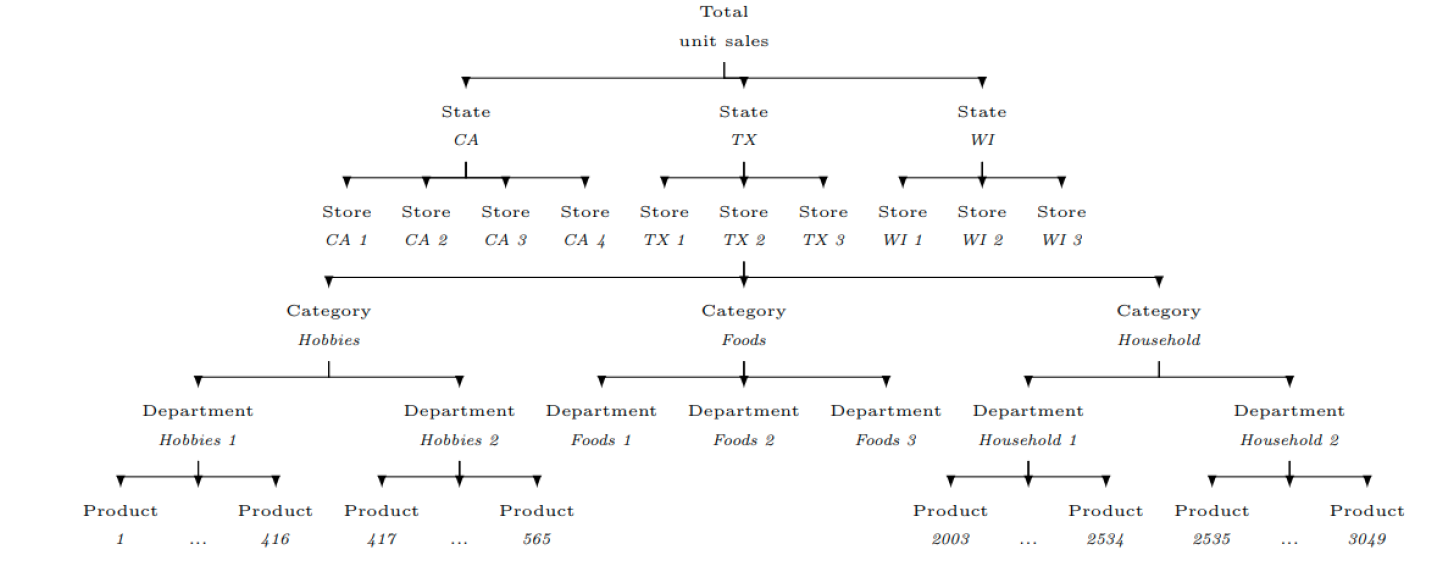

<center><b>Figure 1.</b> An illustration of the hierarchies in the dataset. Aggregation and the subsequent top-down and bottom-up approaches are facilitated by the presented hierarchy</center>


<b>Table 1.</b> Count of series per level in the hierarchy of the data structure. This presents justification on the choice of approach (middle-out) in obtaining the forecasts in all levels.
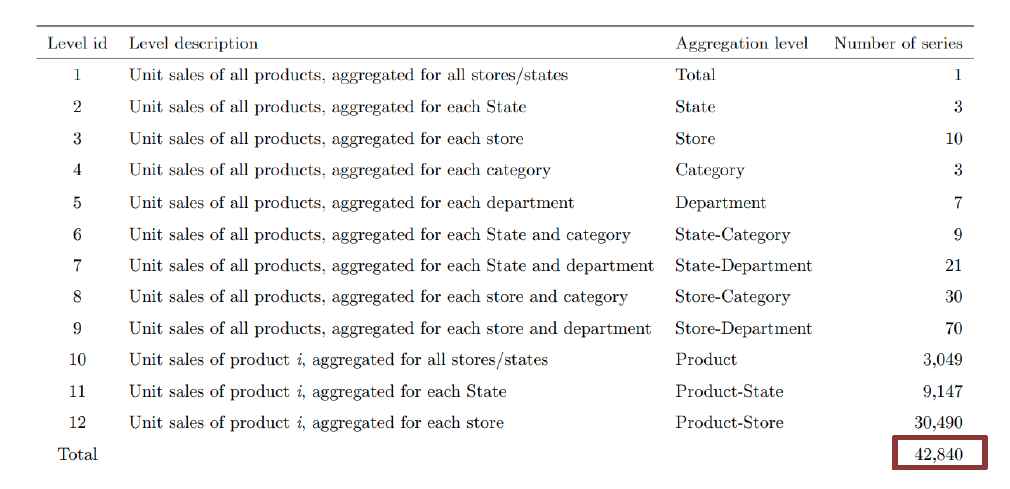

Given the above scenario, the chosen approach is a middle-out approach for reasons that forecasting at higher level ids will require tuning thousands of models and forecasting at lower level ids may result to more errors during the disaggregation to get the higher level id forecasts.

In [17]:
# aggregate to level 9 store-department
train = train.groupby(['store_id', 'dept_id']).sum().T
train.index = pd.date_range(start='2011-01-29', end='2016-05-22', freq='D')
train[train < 5] = np.nan
train = train.interpolate(method='linear')

# train[('CA_4','HOBBIES_2')].fillna(method="bfill", inplace=True)
print(train.isna().any())
train.head(5)

store_id  dept_id    
CA_1      FOODS_1        False
          FOODS_2        False
          FOODS_3        False
          HOBBIES_1      False
          HOBBIES_2      False
                         ...  
WI_3      FOODS_3        False
          HOBBIES_1      False
          HOBBIES_2      False
          HOUSEHOLD_1    False
          HOUSEHOLD_2    False
Length: 70, dtype: bool


store_id      CA_1                                                  \
dept_id    FOODS_1 FOODS_2 FOODS_3 HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
2011-01-29   297.0   674.0  2268.0     528.0      28.0       361.0   
2011-01-30   284.0   655.0  2198.0     489.0       9.0       350.0   
2011-01-31   214.0   396.0  1398.0     409.0       6.0       279.0   
2011-02-01   175.0   476.0  1607.0     383.0       9.0       278.0   
2011-02-02   182.0   354.0  1496.0     263.0       5.0       195.0   

store_id                  CA_2                  ...      WI_2              \
dept_id    HOUSEHOLD_2 FOODS_1 FOODS_2 FOODS_3  ... HOBBIES_2 HOUSEHOLD_1   
2011-01-29       181.0   406.0   212.0  1575.0  ...      10.0       353.0   
2011-01-30       170.0   408.0   227.0  1286.0  ...       7.0       268.0   
2011-01-31       114.0   238.0   138.0   913.0  ...      18.0       250.0   
2011-02-01       123.0   240.0   174.0  1126.0  ...      15.0       305.0   
2011-02-02       135.0   220.0   102.0   956.0  ...      10.5       118.0   

store_id                  WI_3                                      \
dept_id    HOUSEHOLD_2 FOODS_1 FOODS_2 FOODS_3 HOBBIES_1 HOBBIES_2   
2011-01-29        98.0   152.0   583.0  2293.0     256.0      22.0   
2011-01-30        94.0   138.0   585.0  2383.0     342.0      14.0   
2011-01-31        69.0   127.0   575.0  1841.0     228.0      20.0   
2011-02-01        80.0    98.0   533.0  1965.0     183.0      11.0   
2011-02-02        32.0    87.0   340.0  1427.0      70.0       9.5   

store_id                            
dept_id    HOUSEHOLD_1 HOUSEHOLD_2  
2011-01-29       584.0       148.0  
2011-01-30       541.0       195.0  
2011-01-31       420.0       106.0  
2011-02-01       327.0        94.0  
2011-02-02       151.0        53.0  

[5 rows x 70 columns]

We can indeed confirm that we have 70 series (columns). Each corresponding to a combination of store and department id. The next step is to tune a model for each of the series. To do so, we enrich our data further by adding exogenous columns. These are features that indicate calendar dates, specifically, the day, week, month, and year--as well as indicators for events (holidays) and sales promotions.

## Prepare Exogenous Variables

In [18]:
# price exogenous variables
prices = pd.read_csv(PATHS.prices_path)
prices['dept_id'] = prices['item_id'].str.split(pat='_').apply(lambda row: "_".join(row[0:2]))
prices['cat_id'] = prices['dept_id'].str.split(pat='_').apply(lambda row: row[0])
prices.head()

,store_id,item_id,wm_yr_wk,sell_price,dept_id,cat_id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1,HOBBIES
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1,HOBBIES
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1,HOBBIES
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1,HOBBIES
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1,HOBBIES


In [19]:
def get_wk_sell_prices(store_id, dept_id):
    """Return averege sell prices for series store_id-dept_id"""
    return (prices.loc[(prices['store_id']==store_id) & \
                      (prices['dept_id']==dept_id), :]
          .groupby('wm_yr_wk')
          .mean())

def map_wk_to_price(wk_sell_prices, wm_yr_wk):
    """Return average sell price from wk_sell_prices for a wm_yr_wk"""
    return wk_sell_prices.loc[wm_yr_wk]

# test functions, store_id, dept_id, and wm_yr_wk should map to sell price
map_wk_to_price(get_wk_sell_prices('WI_1', 'HOUSEHOLD_1'), 11101)

sell_price    5.156159
Name: 11101, dtype: float64

In [20]:
# calendar, promotions, and holiday events indicator
calendar = pd.read_csv(PATHS.calendar_path)

calendar['date'] = pd.to_datetime(calendar['date'])
calendar.set_index('date', inplace=True)

# include wm_yr_wk to map sell prices (exogenous, numerical)
exo_cols = ['wm_yr_wk', 'wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI']
exo = calendar[exo_cols]

# Transform to zero-based
exo['wday'] = exo['wday'].subtract(1) 
exo['month'] = exo['month'].subtract(1)

events = pd.get_dummies(calendar[['event_type_1', 'event_type_2']], 
                        columns=['event_type_1', 'event_type_2'])
event_types = ['Cultural', 'National', 'Religious', 'Sporting']
events_OHE = pd.DataFrame()
for event in event_types:
    try:
        events_OHE[event] = int(bool(events[f'event_type_1_{event}'] + \
        events[f'event_type_2_{event}']))
    except:
        events_OHE[event] = events[f'event_type_1_{event}']
        
events = events_OHE
# Sanity Check
print(events.sum())

# Exogenous Data
exo = exo.merge(events, on='date')
exo = exo.iloc[0:-28] # Remove excess rows (only used in actual M5)

exo.head(3)
print("Shape: ", exo.shape) # confirm length of data

Cultural     37
National     52
Religious    55
Sporting     18
dtype: int64
Shape:  (1941, 10)


/home/mdorosan/.conda-envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/mdorosan/.conda-envs/atsa/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [21]:
# restructure index column
train.index = exo.index
train.head(3)

# combine into one frame
dataset = train.merge(exo, on='date')
dataset.head(3)

/home/mdorosan/.conda-envs/atsa/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


,"(CA_1, FOODS_1)","(CA_1, FOODS_2)","(CA_1, FOODS_3)","(CA_1, HOBBIES_1)","(CA_1, HOBBIES_2)","(CA_1, HOUSEHOLD_1)","(CA_1, HOUSEHOLD_2)","(CA_2, FOODS_1)","(CA_2, FOODS_2)","(CA_2, FOODS_3)",...,wm_yr_wk,wday,month,snap_CA,snap_TX,snap_WI,Cultural,National,Religious,Sporting
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,297.0,674.0,2268.0,528.0,28.0,361.0,181.0,406.0,212.0,1575.0,...,11101,0,0,0,0,0,0,0,0,0
2011-01-30,284.0,655.0,2198.0,489.0,9.0,350.0,170.0,408.0,227.0,1286.0,...,11101,1,0,0,0,0,0,0,0,0
2011-01-31,214.0,396.0,1398.0,409.0,6.0,279.0,114.0,238.0,138.0,913.0,...,11101,2,0,0,0,0,0,0,0,0


In [ ]:
# !pip install sklearn
# !pip install optuna
# !pip install lightgbm

In [27]:
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import (mean_squared_error, mean_absolute_percentage_error, 
                             mean_absolute_error, make_scorer, r2_score)
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import cross_val_score, cross_validate
import optuna
import lightgbm as lgb
import logging
from datetime import date

%autoreload 2
import utils

In [28]:
logging.basicConfig(filename='phdinds2024_entry_tuning.log', 
                    level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def objective(trial):
    # goss params
    lgb_params = {
        'boosting_type': 'goss',
        'metric' : 'rmse',
        'seed':11,
        'tree_learner': trial.suggest_categorical('tree_learner', ['serial', 'feature', 'voting']),
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 1, log=True),
        'num_leaves':  trial.suggest_int('num_leaves', 2, 2**14)
    } 
    top_rate =  trial.suggest_float("top_rate", 0, 1.0)
    other_rate = trial.suggest_float("other_rate", 0, (1.0 - top_rate)*0.90) 
    
    # corrects the top_rate/other_rate values to only sum to 1
    if (top_rate + other_rate) > 1.0:
        lgb_params['other_rate'] = other_rate / (top_rate + other_rate)
        lgb_params['top_rate'] = top_rate / (top_rate + other_rate)

    other_params = {
        'lookback_endo' : trial.suggest_categorical('lookback_endo', [False, True]), 
        'lookback_exo_num': trial.suggest_categorical('lookback_exo_num', [False, True]), 
        'lookahead_exo_num': trial.suggest_categorical('lookahead_exo_num', [False, True]), 
        'lookback_exo_cat': trial.suggest_categorical('lookback_exo_cat', [False, True]),
        'lookahead_exo_cat': trial.suggest_categorical('lookahead_exo_cat', [False, True]), 
        'lookback' : trial.suggest_int('lookback', 1, 12),
        'delay': trial.suggest_int('delay', 0, 12)
    }
    
    # other create_dataset params
    fixed_params = {
        'dataset': tuning_data, # change
        'exo_cat': exo_cat, # change
        'step': step # 28-step forecasts, prediction horizon
    }
    logging.info(f"{index + 1}/70 Begin optimization for {endo} ")
    logging.info(other_params)
    logging.info(lgb_params)
    # include this in objective function
    X, y, cat_cols_indices =  utils.create_dataset(
            endo=endo, exo_num=exo_num, **fixed_params, **other_params)
    if X is None:
        logging.info("create_dataset FAILED")
        return None    
    
    else:
        logging.info("create_dataset successful")
        logging.info(f"Predictors shape: {X.shape} with mem. usage: {X.nbytes}")
        logging.info(f"Targets shape: {y.shape}")
        logging.info(f"Cat cols indices: {cat_cols_indices}")
        if len(cat_cols_indices) == 0:
            fit_params = None
        else:
            fit_params = {
                'categorical_feature' : cat_cols_indices
            }
        model = lgb.LGBMRegressor(**lgb_params, verbose=-1)
        
        # used in selecting which multiout algo to use
        mor_algo = trial.suggest_categorical('mor_algo', ['morchain', 'mor'])
        
        estimators = {
            'mor': MultiOutputRegressor(model, n_jobs=-1) ,
            'morchain': RegressorChain(model)
        }  
        estimator = estimators[mor_algo]
        logging.info(f"Estimator {mor_algo}")
        logging.info(f"Running Cross Validation...")
        
        ## repeated kfold cv with rmse as scoring parameter, memory intensive
        # rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=11)
        
        mse_scorer = make_scorer(mean_squared_error)
        cv_scores = cross_val_score(estimator=estimator, X=X, y=y, scoring=mse_scorer, 
                                    cv=3, n_jobs=-1, fit_params=fit_params)
        average_rmse = np.mean(np.sqrt(cv_scores))
        logging.info(f"SCORE: {average_rmse}")
        return average_rmse

In [29]:
def reduce_mem_usage(df, verbose=True):
    """Lifted from winning entry in M5 competition, reduces the size of a dataframe"""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    reduction =  100 * (start_mem - end_mem) / (start_mem)
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({reduction:.1f} % reduction)')
    return df

In [30]:
# list all 70 series at level 9, store-department level
series_list = train.columns.to_list()

In [ ]:
today = str(date.today())
for index, series in enumerate(series_list):
    n_trials = 2
    step = 28
    sell_price_arr = get_wk_sell_prices(*series)
    tuning_data = dataset.copy()
    tuning_data['wk_sell_price'] = tuning_data['wm_yr_wk'].apply(lambda val: map_wk_to_price(sell_price_arr, val))
    tuning_data = reduce_mem_usage(tuning_data, verbose=False)
    endo = series
    exo_num = ['wk_sell_price']
    snap_var = 'snap_' + series[0].split('_')[0]
    exo_cat = [snap_var, 'wday', 'month', 'Cultural', 
               'National', 'Religious', 'Sporting']
    study_name = f'{series[0]}-{series[1]}'
    save_dir = os.path.join(PATHS.tuning, f'{today}-tuning')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fname = os.path.join(save_dir, f'{study_name}.db')
    if os.path.exists(fname):
        continue
    study = optuna.create_study(direction='minimize', 
                                study_name=study_name,
                                storage=f'sqlite:///{fname}',
                                load_if_exists=True)
    study.optimize(objective, n_trials=n_trials)

[I 2022-01-03 15:58:11,823] A new study created in RDB with name: TX_3-FOODS_2
[I 2022-01-03 15:59:11,831] Trial 0 finished with value: 91.70984203372666 and parameters: {'tree_learner': 'feature', 'n_estimators': 687, 'learning_rate': 0.002997848535235514, 'num_leaves': 12180, 'top_rate': 0.5284779972070922, 'other_rate': 0.06273690338541385, 'lookback_endo': False, 'lookback_exo_num': True, 'lookahead_exo_num': True, 'lookback_exo_cat': True, 'lookahead_exo_cat': False, 'lookback': 10, 'delay': 9, 'mor_algo': 'mor'}. Best is trial 0 with value: 91.70984203372666.
[I 2022-01-03 15:59:39,478] Trial 1 finished with value: 97.81504033875314 and parameters: {'tree_learner': 'feature', 'n_estimators': 593, 'learning_rate': 0.001245730243084603, 'num_leaves': 1883, 'top_rate': 0.1382285081192588, 'other_rate': 0.5831799692566544, 'lookback_endo': True, 'lookback_exo_num': True, 'lookahead_exo_num': True, 'lookback_exo_cat': False, 'lookahead_exo_cat': False, 'lookback': 12, 'delay': 2, 'mor

## Evaluation

In this section, the tuned models are retrained and evaluated. In a **middle-out approach**, we only tuned the models in forecasting `level_id` 9, we then use the forecasts at `level_id` 9 as basis for the other levels. The functions used are  are demonstrated in the `hierarchical_forecasting.ipynb` notebook of this Chapter 8 - Winningest Methods.

### Generate Base Forecasts: `level_id` 9

In [99]:
%autoreload 2
import utils
import joblib

#### Rebuild data

In [100]:
calendar = pd.read_csv(PATHS.calendar_path)

calendar['date'] = pd.to_datetime(calendar['date'])
calendar.set_index('date', inplace=True)

exo_cols = ['wm_yr_wk', 'wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI']
exo = calendar[exo_cols]

# Transform to zero-based
exo['wday'] = exo['wday'].subtract(1) 
exo['month'] = exo['month'].subtract(1)

events = pd.get_dummies(calendar[['event_type_1', 'event_type_2']], 
                        columns=['event_type_1', 'event_type_2'])
event_types = ['Cultural', 'National', 'Religious', 'Sporting']
events_OHE = pd.DataFrame()
for event in event_types:
    try:
        events_OHE[event] = int(bool(events[f'event_type_1_{event}'] + \
        events[f'event_type_2_{event}']))
    except:
        events_OHE[event] = events[f'event_type_1_{event}']
        
events = events_OHE

# Exogenous Data
exo = exo.merge(events, on='date')

In [101]:
test = pd.read_csv(PATHS.test_path)
train = pd.read_csv(PATHS.train_path)

train = train.groupby(['store_id', 'dept_id']).sum().T
train.index = pd.date_range(start='2011-01-29', end='2016-05-22', freq='D')
train[train < 5] = np.nan
train = train.interpolate(method='linear')
train[('CA_4','HOBBIES_2')].fillna(method="bfill",inplace=True)

test = test.groupby(['store_id', 'dept_id']).sum().T

dataset = pd.concat([train, test])

In [102]:
dataset.index = exo.index
dataset = dataset.merge(exo, on='date')
dataset.head(3)

,"(CA_1, FOODS_1)","(CA_1, FOODS_2)","(CA_1, FOODS_3)","(CA_1, HOBBIES_1)","(CA_1, HOBBIES_2)","(CA_1, HOUSEHOLD_1)","(CA_1, HOUSEHOLD_2)","(CA_2, FOODS_1)","(CA_2, FOODS_2)","(CA_2, FOODS_3)",...,wm_yr_wk,wday,month,snap_CA,snap_TX,snap_WI,Cultural,National,Religious,Sporting
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,297,674,2268,528,28,361,181,406,212,1575,...,11101,0,0,0,0,0,0,0,0,0
2011-01-30,284,655,2198,489,9,350,170,408,227,1286,...,11101,1,0,0,0,0,0,0,0,0
2011-01-31,214,396,1398,409,6,279,114,238,138,913,...,11101,2,0,0,0,0,0,0,0,0


#### Retrain using best hyparparameters

In [103]:
def get_lgb_params(params):
    """Return lgb params from best parameter dict"""
    lgb_params = {
        'boosting_type': 'goss',
        'metric' : 'rmse',
        'seed':11,
        'tree_learner': params['tree_learner'],
        'n_estimators': params['n_estimators'],
        'learning_rate' : params['learning_rate'],
        'num_leaves':  params['num_leaves']
    } 
    # corrects the top_rate/other_rate values to only sum to 1
    other_rate = params['other_rate']
    top_rate = params['top_rate']
    if (top_rate + other_rate) > 1.0:
        lgb_params['other_rate'] = other_rate / (top_rate + other_rate)
        lgb_params['top_rate']  = top_rate / (top_rate + other_rate)

    return lgb_params

def get_other_params(params):
    """Return other params from best parameter dict"""
    other_params = {
        'lookback_endo' : params['lookback_endo'], 
        'lookback_exo_num': params['lookback_exo_num'], 
        'lookahead_exo_num': params['lookahead_exo_num'], 
        'lookback_exo_cat': params['lookback_exo_cat'],
        'lookahead_exo_cat': params['lookahead_exo_cat'], 
        'lookback' : params['lookback'],
        'delay': params['delay']
    }
    return other_params

In [105]:
# initialize predictions dataframe : level 9
level9_forecasts = pd.DataFrame(index=dataset.iloc[-28:,:].index, 
                                columns=dataset.columns)
logging.basicConfig(filename='phdinds2024_entry_evaluation.log', level=logging.INFO)

failed_series = []
today = "2021-12-30" # change date
for index, series in enumerate(series_list):
    logging.info("================================")
    logging.info(f"Begin {series} : {index + 1}/70")
    try:
        # init input params
        step = 28
        endo = series
        exo_num = ['wk_sell_price']
        snap_var = 'snap_' + series[0].split('_')[0]
        exo_cat = [snap_var, 'wday', 'month', 'Cultural', 
                'National', 'Religious', 'Sporting']

        # create sell prices column
        sell_price_arr = get_wk_sell_prices(*series)
        temp_data = dataset.copy()
        temp_data['wk_sell_price'] = temp_data['wm_yr_wk'].apply(lambda val: map_wk_to_price(sell_price_arr, val))
        temp_data = reduce_mem_usage(temp_data)

        # retrieve study data
        study_name = f'{series[0]}-{series[1]}'
        save_dir = os.path.join(PATHS.tuning, f'{today}-tuning')
        fname = os.path.join(save_dir, f'{study_name}.db')
        study = optuna.load_study(study_name=study_name,
                                storage=f'sqlite:///{fname}')
        logging.info(f"Load {study_name} study SUCCESS")

        # get best params
        params = study.best_params
        lgb_params = get_lgb_params(params)
        other_params = get_other_params(params)
        
        # split
        holdout_data = temp_data[-(step + other_params['lookback'] + other_params['delay']):]
        train_data = temp_data[:-step]

        # other create_dataset params
        fixed_params = {
            'endo': endo, 
            'exo_cat': exo_cat,
            'exo_num': exo_num,
            'step': step # 28-step forecasts, prediction horizon
        }

        train_X, train_y, train_cat_cols = utils.create_dataset(
            dataset=train_data, **fixed_params, **other_params)
        logging.info("Create train_data SUCCESS")
        holdout_X, holdout_y, holdout_cat_cols = utils.create_dataset(
            dataset=holdout_data, **fixed_params, **other_params)
        logging.info("Create holdout_data SUCCESS")

        fit_params = {
            'categorical_feature' : train_cat_cols
        }
        model = lgb.LGBMRegressor(**lgb_params, verbose=-1)
        estimators = {
            'mor': MultiOutputRegressor(model, n_jobs=-1) ,
            'morchain': RegressorChain(model)
        }  
        estimator = estimators[params['mor_algo']]
        
        # filter, for 2nd run, logging of failed trains
        model_dir = os.path.join(root, 'trained_models')
        fpath = os.path.join(model_dir, f'{study_name}.joblib')
        if os.path.exists(fpath):
            continue

        # fit
        logging.info(f"Fitting...")
        trained_est = estimator.fit(train_X, train_y, **fit_params)

        # save
        model_dir = os.path.join(root, 'trained_models')
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        joblib.dump(trained_est, model_dir + f'/{study_name}.joblib') 
        # trained_est = load( root + f'trained_models/{study_name}.joblib') # load 

        # predict
        logging.info(f"Generating Forecast...")
        y_pred = trained_est.predict(holdout_X)
        level9_forecasts[series] = np.round(y_pred[0]).astype(int)
        logging.info(f"Retrain-Predict {series} SUCCESS")
    except:
        logging.info("Retrain-Predict FAIL")
        failed_series.append(series)

Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage decreased to  0.29 Mb (75.2 % reduction)
Mem. usage d

In [119]:
print(failed_series)

# inspec params of failed retrains
for series in failed_series:
    print(series)
    study_name = f'{series[0]}-{series[1]}'
    save_dir = os.path.join(root, 'tuned_models', __author__, f'{today}-tuning')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fname = os.path.join(save_dir, f'{study_name}.db')
    study = optuna.load_study(study_name=study_name,
                            storage=f'sqlite:///{fname}')
    res_df = study.trials_dataframe()
    display(res_df)

[('CA_1', 'FOODS_2'), ('CA_1', 'HOBBIES_1'), ('CA_1', 'HOBBIES_2')]
('CA_1', 'FOODS_2')


,number,value,datetime_start,datetime_complete,duration,params_delay,params_learning_rate,params_lookahead_exo_cat,params_lookahead_exo_num,params_lookback,params_lookback_endo,params_lookback_exo_cat,params_lookback_exo_num,params_mor_algo,params_n_estimators,params_num_leaves,params_other_rate,params_top_rate,params_tree_learner,state
0,0,76.559878,2021-12-30 12:02:55.160144,2021-12-30 12:16:11.456844,0 days 00:13:16.296700,7,0.002480,False,False,11,False,True,True,mor,664,11007,0.288508,0.413435,feature,COMPLETE
1,1,79.696362,2021-12-30 12:16:12.086460,2021-12-30 13:13:06.260470,0 days 00:56:54.174010,2,0.103313,False,True,7,True,True,False,morchain,681,3182,0.006799,0.959209,serial,COMPLETE


('CA_1', 'HOBBIES_1')


,number,value,datetime_start,datetime_complete,duration,params_delay,params_learning_rate,params_lookahead_exo_cat,params_lookahead_exo_num,params_lookback,params_lookback_endo,params_lookback_exo_cat,params_lookback_exo_num,params_mor_algo,params_n_estimators,params_num_leaves,params_other_rate,params_top_rate,params_tree_learner,state
0,0,97.350394,2021-12-30 13:39:47.371462,2021-12-30 13:49:49.617431,0 days 00:10:02.245969,8,0.038945,True,False,2,True,True,False,mor,608,1326,0.005422,0.696175,feature,COMPLETE
1,1,94.852027,2021-12-30 13:49:49.889857,2021-12-30 14:00:07.006791,0 days 00:10:17.116934,8,0.036254,False,False,1,False,True,True,mor,974,8102,0.231498,0.499145,feature,COMPLETE


('CA_1', 'HOBBIES_2')


,number,value,datetime_start,datetime_complete,duration,params_delay,params_learning_rate,params_lookahead_exo_cat,params_lookahead_exo_num,params_lookback,params_lookback_endo,params_lookback_exo_cat,params_lookback_exo_num,params_mor_algo,params_n_estimators,params_num_leaves,params_other_rate,params_top_rate,params_tree_learner,state
0,0,11.689200,2021-12-30 14:00:15.067565,2021-12-30 14:10:17.664342,0 days 00:10:02.596777,7,0.126094,True,True,10,True,False,True,mor,918,1160,0.773435,0.009296,feature,COMPLETE
1,1,19.801871,2021-12-30 14:10:18.187150,2021-12-30 14:17:28.954147,0 days 00:07:10.766997,6,0.217986,False,True,1,False,True,False,morchain,130,14416,0.032402,0.896781,feature,COMPLETE


In [77]:
preds_path = os.path.join(PATHS.predictions, '9.csv')
level9_forecasts[series_list].to_csv(preds_path)

In [78]:
# true values
true = pd.read_csv(PATHS.test_path)

# create multi-index for per level series references
item_id = true['item_id']
true = true.set_index(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'], drop=True)
true.head(3)

d_1942  d_1943  d_1944  \
state_id store_id cat_id  dept_id   item_id                                 
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       2       0       1   
                                    HOBBIES_1_002       0       2       0   
                                    HOBBIES_1_003       0       0       0   

                                                   d_1945  d_1946  d_1947  \
state_id store_id cat_id  dept_id   item_id                                 
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       0       0       1   
                                    HOBBIES_1_002       1       0       1   
                                    HOBBIES_1_003       0       0       1   

                                                   d_1948  d_1949  d_1950  \
state_id store_id cat_id  dept_id   item_id                                 
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       4       3       0   
                                    HOBBIES_1_002       0       1       0   
                                    HOBBIES_1_003       0       0       0   

                                                   d_1951  ...  d_1960  \
state_id store_id cat_id  dept_id   item_id                ...           
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       0  ...       2   
                                    HOBBIES_1_002       0  ...       1   
                                    HOBBIES_1_003       0  ...       1   

                                                   d_1961  d_1962  d_1963  \
state_id store_id cat_id  dept_id   item_id                                 
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       1       2       0   
                                    HOBBIES_1_002       0       0       1   
                                    HOBBIES_1_003       3       2       1   

                                                   d_1964  d_1965  d_1966  \
state_id store_id cat_id  dept_id   item_id                                 
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       0       1       0   
                                    HOBBIES_1_002       0       0       2   
                                    HOBBIES_1_003       0       2       1   

                                                   d_1967  d_1968  d_1969  
state_id store_id cat_id  dept_id   item_id                                
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001       1       3       1  
                                    HOBBIES_1_002       1       1       0  
                                    HOBBIES_1_003       0       1       1  

[3 rows x 28 columns]

### Bottom Up

In this section, we obtain the forecasts for `level_id`s 1 to 8 using a bottom up approach. 

In [79]:
level_indexes = utils.level_indexes

In [80]:
# restructure base forecacst (level 9) dataframe
preds_path = os.path.join(PATHS.predictions, '9.csv')
level9_forecasts = pd.read_csv(preds_path, index_col='date')
m_index = pd.MultiIndex.from_tuples(series_list, names=['store_id', 'dept_id'])
level9_forecasts = level9_forecasts.T.reset_index(drop=True)
level9_forecasts.index = m_index

# state_id and cat_id indexes
state_id = [i[0].split('_')[0] for i in level9_forecasts.index]
cat_id = [i[1].split('_')[0] for i in level9_forecasts.index]

# create new multi-index for per level series references
level9_forecasts = level9_forecasts.reset_index()
level9_forecasts['state_id'] = state_id
level9_forecasts['cat_id'] = cat_id
level9_forecasts['item_id'] = item_id
level9_forecasts.set_index(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'], inplace=True, drop=True)
level9_forecasts.head(3)

date                                            2016-05-23  2016-05-24  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         283         317   
                         FOODS_2 HOBBIES_1_002         495         451   
                         FOODS_3 HOBBIES_1_003        2118        1843   

date                                            2016-05-25  2016-05-26  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         302         328   
                         FOODS_2 HOBBIES_1_002         374         370   
                         FOODS_3 HOBBIES_1_003        1763        1867   

date                                            2016-05-27  2016-05-28  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         407         456   
                         FOODS_2 HOBBIES_1_002         444         600   
                         FOODS_3 HOBBIES_1_003        2217        2655   

date                                            2016-05-29  2016-05-30  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         397         343   
                         FOODS_2 HOBBIES_1_002         600         523   
                         FOODS_3 HOBBIES_1_003        2953        2432   

date                                            2016-05-31  2016-06-01  ...  \
state_id store_id cat_id dept_id item_id                                ...   
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         376         353  ...   
                         FOODS_2 HOBBIES_1_002         465         425  ...   
                         FOODS_3 HOBBIES_1_003        1927        1964  ...   

date                                            2016-06-10  2016-06-11  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         416         451   
                         FOODS_2 HOBBIES_1_002         559         650   
                         FOODS_3 HOBBIES_1_003        2506        2971   

date                                            2016-06-12  2016-06-13  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         414         330   
                         FOODS_2 HOBBIES_1_002         660         537   
                         FOODS_3 HOBBIES_1_003        3124        2335   

date                                            2016-06-14  2016-06-15  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         348         326   
                         FOODS_2 HOBBIES_1_002         453         421   
                         FOODS_3 HOBBIES_1_003        2065        2018   

date                                            2016-06-16  2016-06-17  \
state_id store_id cat_id dept_id item_id                                 
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         342         425   
                         FOODS_2 HOBBIES_1_002         366         447   
                         FOODS_3 HOBBIES_1_003        1965        2403   

date                                            2016-06-18  2016-06-19  
state_id store_id cat_id dept_id item_id                                
CA       CA_1     FOODS  FOODS_1 HOBBIES_1_001         457         420  
                         FOODS_2 HOBBIES_1_002         558         645  
                         FOODS_3 HOBBIES_1_003        2980        3133  

[3 rows x 28 columns]

In [81]:
# get reference file for per series/level weight used in WRMSSE
weights_df = pd.read_csv(PATHS.weights_path)
weights_df = weights_df.set_index(['Level_id', 'Agg_Level_1', 'Agg_Level_2'], drop=True)
weights_df.head(6)

Dollar_Sales    weight
Level_id Agg_Level_1   Agg_Level_2                        
Level12  HOBBIES_1_001 CA_1               276.54  0.000071
         HOBBIES_1_002 CA_1                27.79  0.000007
         HOBBIES_1_003 CA_1                62.37  0.000016
         HOBBIES_1_004 CA_1               227.36  0.000058
         HOBBIES_1_005 CA_1               112.32  0.000029
...                                          ...       ...
Level3   WI_3          X               323220.05  0.082856
Level2   CA            X              1721795.38  0.441376
         TX            X              1076515.09  0.275960
         WI            X              1102665.55  0.282664
Level1   Total         X              3900976.02  1.000000

[42840 rows x 2 columns]

In [82]:
# initialize rmsse function: per series rmsse calculation
def rmsse(y_true, y_pred, ts):
    """Return the root-mean-squred error scaled according to reference
    series, ts"""
    y_true = y_true.values
    y_pred = y_pred.values
    score = np.sqrt(np.mean((y_true - y_pred)**2)/ np.mean((ts[1:] - ts[:-1])**2))
    return score

# use original train series per level as rmsse reference, ts
rmsse_ref = pd.read_csv(PATHS.train_path)
rmsse_ref.head(3)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1


In [83]:
def scorer(row, forecasts, ts, weights_df, level):
    """Return weighted rmsse score for a series (row)
    """
    temp_ts = ts.loc[row.name]
    temp_ts = temp_ts.values
    
    raw = rmsse(row, forecasts.loc[row.name], temp_ts)
    
    if type(row.name) is tuple:
        location = (level, row.name[0], row.name[1])
    else:
        location = (level, row.name, 'X')
    weight = weights_df.loc[location]['weight']
    weighted = raw * weight
    return weighted

In [84]:
level_bu = list(level_indexes.keys())[0:8]

WRMSSE = {}
for level in tqdm(level_bu):
    forecasts = utils.generate_bu(level, level9_forecasts)
    index = level_indexes[level]
    if index:
        actual = true.groupby(index).sum()
        ts = rmsse_ref.groupby(index).sum()
        scores = actual.apply(lambda row: scorer(row, forecasts, ts, weights_df, level), axis=1)
        WRMSSE[level] = scores.sum()
    else:
        actual = true.sum()
        ts = rmsse_ref.groupby(['item_id','dept_id','cat_id','store_id', 'state_id']).sum()
        ts = ts.sum()
        raw = rmsse(forecasts, actual, ts.values)
        weight = weights_df.loc[(level, 'Total', 'X')]['weight']
        WRMSSE[level] = raw*weight
print(WRMSSE)

100%|██████████| 8/8 [00:09<00:00,  1.13s/it]

{'Level1': 0.26213229153246365, 'Level2': 0.34145714592099946, 'Level3': 0.4573486076270619, 'Level4': 0.33907295004528615, 'Level5': 0.4039149543499785, 'Level6': 0.4298460757434355, 'Level7': 0.5152629748972829, 'Level8': 0.5414872731671356}


### Top Down

Now, we have obtained the forecasts for levels 1 to 9. We now obtain the forecasts in the lower/finer levels in the hierarchy (ie. higher level ids, `level_id`s 10 to 12). To do so, we perform a top-down approach.

In [85]:
# get proportions, proportions_reference.csv from heirarchical_forecasting
prop_reference = pd.read_csv('dataset/proportions_reference.csv')
prop_reference.set_index(['state_id', 'store_id', 'item_id', 'dept_id', 'cat_id'])
prop_reference.head(3)

,item_id,dept_id,cat_id,store_id,state_id,d_1886,d_1887,d_1888,d_1889,d_1890,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [86]:
level_td = list(level_indexes.keys())[9:]

for level in tqdm(level_td):
    forecasts = utils.generate_td(level, level9_forecasts, utils.get_ave_proportions,
                                  prop_reference=prop_reference, T=28)
    index = level_indexes[level]
    if index:
        actual = true.groupby(index).sum()
        ts = rmsse_ref.groupby(index).sum()
        scores = actual.apply(lambda row: scorer(row, forecasts, ts, weights_df, level), axis=1)
        WRMSSE[level] = scores.sum()
    else:
        actual = true.sum()
        ts = rmsse_ref.groupby(['item_id','dept_id','cat_id','store_id', 'state_id']).sum()
        ts = ts.sum()
        raw = rmsse(forecasts, actual, ts.values)
        weight = weights_df.loc[(level, 'Total', 'X')]['weight']
        WRMSSE[level] = raw * weight
print(WRMSSE)

100%|██████████| 3/3 [00:43<00:00, 14.60s/it]

{'Level1': 0.26213229153246365, 'Level2': 0.34145714592099946, 'Level3': 0.4573486076270619, 'Level4': 0.33907295004528615, 'Level5': 0.4039149543499785, 'Level6': 0.4298460757434355, 'Level7': 0.5152629748972829, 'Level8': 0.5414872731671356, 'Level10': 1.2882929671588705, 'Level11': 1.2010573967191414, 'Level12': 1.1495073746392594}


In [87]:
# level9 scores
index = ['store_id', 'dept_id'] # level9
forecasts = level9_forecasts.groupby(index).sum()
actual = true.groupby(index).sum()
ts = rmsse_ref.groupby(index).sum()
scores = actual.apply(lambda row: scorer(row, forecasts, ts, weights_df, 'Level9'), axis=1)
print('Level 9 MOR WRMSSE: ', scores.sum())
WRMSSE['Level9'] = scores.sum()
print(WRMSSE)

Level 9 MOR WRMSSE:  0.6497933780056879
{'Level1': 0.26213229153246365, 'Level2': 0.34145714592099946, 'Level3': 0.4573486076270619, 'Level4': 0.33907295004528615, 'Level5': 0.4039149543499785, 'Level6': 0.4298460757434355, 'Level7': 0.5152629748972829, 'Level8': 0.5414872731671356, 'Level10': 1.2882929671588705, 'Level11': 1.2010573967191414, 'Level12': 1.1495073746392594, 'Level9': 0.6497933780056879}


In [88]:
WRMSSE_new = {k: [v] for k,v in WRMSSE.items()}
res = pd.DataFrame.from_dict(WRMSSE_new)
res.index = ['WRMSSE']
res['Average'] = np.mean(list(WRMSSE.values()))
res

,Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level10,Level11,Level12,Level9,Average
WRMSSE,0.262132,0.341457,0.457349,0.339073,0.403915,0.429846,0.515263,0.541487,1.288293,1.201057,1.149507,0.649793,0.631598


In [54]:
WRMSSE_new = {k: [v] for k,v in WRMSSE.items()}
res = pd.DataFrame.from_dict(WRMSSE_new)
res.index = ['WRMSSE']
res['Average'] = np.mean(list(WRMSSE.values()))
res

,Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level10,Level11,Level12,Level9,Average
WRMSSE,0.261865,0.331752,0.448894,0.346394,0.408096,0.425779,0.510989,0.535929,1.288514,1.201196,1.149403,0.646023,0.62957


### Final Score

Let's see where we are at. Rank 50 in M5 has an `average WRMSSE` of `0.576`. Also, if we beat the the top performing benchmark which is an Exponential Smoothing (`0.671`) using the Bottom Up approach, we are already at the top 7.5% of the competition.

In [89]:
print("Ave WRMSSE: ", np.mean(list(WRMSSE.values())))

# prev lvl9 0.64
# prev ave 0.629

Ave WRMSSE:  0.6315977824838837


## M5: Best Models

1st: `0.52` Senior undergraduate student in SK - LightGBM models were trained to produce forecasts for the product-store series using data per store (10 models), store-category (30 models), and store-department (70 models). Two variations: recursive and non-recursive. Total of 220 models were built and each series was forecast using the average of 6 models. Each one exploiting a different learning approach and train set.

2nd: LightGBM + N-BEATS (DL for time series forecasting)
3rd: LSTM
4th: Weekly forecasting of the horizon (28 days chopped into weeks) using LGBM trained on store-level data.
5th: LGBM per department-level series.